- https://www.adrianbulat.com/downloads/FG20/fast_human_pose.pdf
- https://arxiv.org/pdf/1603.06937.pdf (Figure 4)

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
%matplotlib inline

In [2]:
import os
import sys
import torch
sys.path.append("/home/michael/CascadedPoseEstimation/lib")
from core.config import config
from core.config import update_config

In [3]:
import models.pose_resnet
import models.unet
import models.cascaded_pose_resnet
import models.pose_stacked_hg
import torch.nn as nn
from typing import Dict, Iterable, Callable
from utils.utils import create_logger

In [4]:
cfg_paths = [
  "/home/michael/CascadedPoseEstimation/experiments/mpii/resnet18/baseline.yaml",  # 0
  "/home/michael/CascadedPoseEstimation/experiments/mpii/hourglass/baseline_2.yaml",  # 1
  "/home/michael/CascadedPoseEstimation/experiments/mpii/hourglass/hourglass_2__td_1_parallel.yaml",  # 2
  "/home/michael/CascadedPoseEstimation/experiments/mpii/hourglass/hourglass_2__td_1_serial.yaml",  # 3
  "/home/michael/CascadedPoseEstimation/experiments/mpii/hourglass/baseline_4.yaml",  # 4
  "/home/michael/CascadedPoseEstimation/experiments/mpii/hourglass/hourglass_4__td_1_parallel.yaml",  # 5
]

In [5]:
cfg_path = cfg_paths[2]
cfg_path

'/home/michael/CascadedPoseEstimation/experiments/mpii/hourglass/hourglass_2__td_1_parallel.yaml'

In [6]:
config["MODEL"]["EXTRA"]

{'CASCADED': False,
 'CASCADED_SCHEME': 'parallel',
 'NUM_LAYERS': 50,
 'DECONV_WITH_BIAS': False,
 'NUM_DECONV_LAYERS': 3,
 'NUM_DECONV_FILTERS': [256, 256, 256],
 'NUM_DECONV_KERNELS': [4, 4, 4],
 'FINAL_CONV_KERNEL': 1,
 'TARGET_TYPE': 'gaussian',
 'HEATMAP_SIZE': [64, 64],
 'SIGMA': 2}

In [7]:
update_config(cfg_path)

/home/michael/CascadedPoseEstimation/lib/core/config.py:181: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  exp_config = edict(yaml.load(f))


In [8]:
# Setup logger
logger, output_dir, tb_log_dir = create_logger(config, cfg_path, 'valid')
output_dir = "../" + output_dir
output_dir

=> creating output/mpii/hourglass_x2__cascaded_td(1.0)__parallel
=> creating log/mpii/hourglass_x2__cascaded_td(1.0)__parallel/hourglass_2__td_1_parallel_2021-09-13-23-32


'../output/mpii/hourglass_x2__cascaded_td(1.0)__parallel'

# Dataset

In [9]:
import torchvision.transforms as transforms
import dataset
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import seaborn as sns

In [10]:
# Data loading code
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [11]:
gpus = [0]

valid_dataset = eval('dataset.'+config.DATASET.DATASET)(
    config,
    "../" + config.DATASET.ROOT,
    config.DATASET.TEST_SET,
    False,
    transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=config.TEST.BATCH_SIZE*len(gpus),
    shuffle=False,
    num_workers=config.WORKERS,
    pin_memory=True
)

/home/michael/anaconda3/envs/pest/lib/python3.7/site-packages/json_tricks/nonp.py:225: JsonTricksDeprecation: `json_tricks.load(s)` stripped some comments, but `ignore_comments` was not passed; in the next major release, the behaviour when `ignore_comments` is not passed will change; it is recommended to explicitly pass `ignore_comments=True` if you want to strip comments; see https://github.com/mverleg/pyjson_tricks/issues/74
  JsonTricksDeprecation)
=> load 2958 samples


In [12]:
for X, y, z, h in valid_loader:
  break

# Model

In [47]:
def count_parameters(model, trainable=False):
  if trainable:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
  else:
    return sum(p.numel() for p in model.parameters())

In [48]:
# config['MODEL']['EXTRA']['CASCADED_SCHEME'] = 'parallel'

In [179]:
class FeatureExtractor(nn.Module):
  def __init__(self, model, layer_suffix="identity_mapping"):
    super().__init__()
    self.model = model
    self.layer_suffix = layer_suffix
    self._activation = {}
    self.setup()
    
  def _hook_fxn(self, name):
    # the hook signature
    # Inputs: model, input, output
    def hook(model, input, output):
      if self._log_active:
        self._activation[name] = {
            "input": input[0].detach(),
            "output": output.detach(),
        }
    return hook

  def setup(self):
    self.hooks = []
    for name, module in self.model.named_modules():
      if name.endswith(self.layer_suffix) and "hg" in name:
        print(f"Hooking into:\t{name}")
        hook_i = module.register_forward_hook(self._hook_fxn(name))
        self.hooks.append(hook_i)
  
  def forward(self, x, t=0):
    for t_i in range(t+1):
      self._log_active = t_i == t
      _ = self.model(x, t_i)
      
    for hook in self.hooks:
      hook.remove()
    return self._activation

In [180]:
def get_state_dict(output_dir, config, logger, use_best=False):
  if config.TEST.MODEL_FILE:
    logger.info('=> loading model from {}'.format(config.TEST.MODEL_FILE))
    state_dict = torch.load(config.TEST.MODEL_FILE)
  else:
    ckpt_path = os.path.join(output_dir, f"final_state.pth.tar")
    
    if os.path.exists(ckpt_path) and not use_best:
      logger.info('=> loading model from {}'.format(ckpt_path))
      state_dict = torch.load(ckpt_path)
    else:
      ckpt_path = os.path.join(output_dir, f"model_best.pth.tar")
      logger.info('=> loading model from {}'.format(ckpt_path))
      state_dict = torch.load(ckpt_path)
  
  if "state_dict" in state_dict:
    state_dict = state_dict["state_dict"]
#       # Fix
#       state_dict = OrderedDict()
#       for k, v in state_dict_src.items():
#         k = k.replace("module.", "")
#         state_dict[k] = v
        
  return state_dict

In [181]:
def load_model(config, output_dir, logger, load_best_ckpt=True):
  # Setup model
  if config.MODEL.NAME == "pose_resnet":
    if config.MODEL.CASCADED:
      model = models.cascaded_pose_resnet.get_pose_net(config, is_train=False)
    else:
      model = models.pose_resnet.get_pose_net(config, is_train=False)
  elif config.MODEL.NAME == "unet":
      model = models.unet.get_pose_net(config, is_train=False)
  elif config.MODEL.NAME == "pose_stacked_hg":
      model = models.pose_stacked_hg.get_pose_net(config, is_train=False)

  if config.MODEL.CASCADED:
      config.MODEL.N_TIMESTEPS = model.timesteps

  # Load state dict
  state_dict = get_state_dict(output_dir, 
                              config, 
                              logger, 
                              use_best=load_best_ckpt)

  # Load previous model
  model.load_state_dict(state_dict)
  return model

In [182]:
def avg_results(alpha_features):
  alpha_avg = {}
  for k, v in alpha_features.items():
    in_v = v["input"]
    out_v = v["output"]
    alpha_avg[k] = {
      "input": in_v.mean(dim=(0,2,3)).numpy(),
      "output": out_v.mean(dim=(0,2,3)).numpy(),
    }
  return alpha_avg

In [183]:
def plot_alpha_features(avg_alpha_features, t=0):
  n_plots = len(avg_alpha_features)
  fig, axes = plt.subplots(n_plots, 1, figsize=(12,4*n_plots))
  for i, (k, v) in enumerate(avg_alpha_features.items()):
    ax_i = axes[i]
    flat_in_v = v["input"]
    flat_out_v = v["output"]
    df_dict = defaultdict(list)
    for v in flat_in_v:
      df_dict["key"].append("in")
      df_dict["val"].append(v)
    for v in flat_out_v:
      df_dict["key"].append("out")
      df_dict["val"].append(v)
    layer_df = pd.DataFrame(df_dict)
    g = sns.histplot(x="val", 
                     hue="key", 
                     binwidth=0.05,
                     data=layer_df, 
                     stat="probability",
                     ax=ax_i)
    ax_i.set_xlim((-1.5, 1.5))
    
    title = f"{k} (t={t})"
    ax_i.set_title(title)
  plt.tight_layout()

In [184]:
# skip_conv_feature_extractor = FeatureExtractor(model, layer_suffix="identity_mapping.skip_conv")
# skip_conv_features = skip_conv_feature_extractor(X, t=0)

In [185]:
def check_same(prev_avg_alpha, prev_vals):
  for k, prev_vals in prev_avg_alpha.items():
    for key, prev_val in prev_vals.items():
      v = avg_alpha[k][key]
      if np.all(v == prev_val):
        print(f"{k} {key} All same!")

In [190]:
df_dict = defaultdict(list)
n_timesteps = model.timesteps
prev_avg_alpha = None
for t in range(n_timesteps):
  model = load_model(config, output_dir, logger, load_best_ckpt=True)
  print(f"t={t}/{n_timesteps}...")
  alpha_feature_extractor = FeatureExtractor(model, layer_suffix="identity_mapping")
  alpha_features = alpha_feature_extractor(X, t=t)
  avg_alpha = avg_results(alpha_features)
  if prev_avg_alpha is not None:
    check_same(prev_avg_alpha, prev_vals)
  prev_avg_alpha = avg_alpha
  # plot_alpha_features(avg_alpha, t=t)
  for layer_key, layer_vals in avg_alpha.items():
    for in_val, out_val in zip(layer_vals["input"], layer_vals["output"]):
      df_dict["in_val"].append(in_val)
      df_dict["out_val"].append(out_val)
      df_dict["layer"].append(layer_key)
      df_dict["t"].append(t)
    
  del model
  del alpha_feature_extractor
df = pd.DataFrame(df_dict)

=> loading model from ../output/mpii/hourglass_x2__cascaded_td(1.0)__parallel/model_best.pth.tar


t=0/6...
Hooking into:	hgs.0.encode_1.0.identity_mapping
Hooking into:	hgs.0.encode_2.0.identity_mapping
Hooking into:	hgs.0.encode_3.0.identity_mapping
Hooking into:	hgs.0.encode_4.0.identity_mapping
Hooking into:	hgs.1.encode_1.0.identity_mapping
Hooking into:	hgs.1.encode_2.0.identity_mapping
Hooking into:	hgs.1.encode_3.0.identity_mapping
Hooking into:	hgs.1.encode_4.0.identity_mapping


=> loading model from ../output/mpii/hourglass_x2__cascaded_td(1.0)__parallel/model_best.pth.tar


t=1/6...
Hooking into:	hgs.0.encode_1.0.identity_mapping
Hooking into:	hgs.0.encode_2.0.identity_mapping
Hooking into:	hgs.0.encode_3.0.identity_mapping
Hooking into:	hgs.0.encode_4.0.identity_mapping
Hooking into:	hgs.1.encode_1.0.identity_mapping
Hooking into:	hgs.1.encode_2.0.identity_mapping
Hooking into:	hgs.1.encode_3.0.identity_mapping
Hooking into:	hgs.1.encode_4.0.identity_mapping
hgs.0.encode_1.0.identity_mapping input All same!
hgs.0.encode_1.0.identity_mapping output All same!
hgs.0.encode_2.0.identity_mapping input All same!
hgs.0.encode_2.0.identity_mapping output All same!
hgs.0.encode_3.0.identity_mapping input All same!
hgs.0.encode_3.0.identity_mapping output All same!
hgs.0.encode_4.0.identity_mapping input All same!
hgs.0.encode_4.0.identity_mapping output All same!


=> loading model from ../output/mpii/hourglass_x2__cascaded_td(1.0)__parallel/model_best.pth.tar


t=2/6...
Hooking into:	hgs.0.encode_1.0.identity_mapping
Hooking into:	hgs.0.encode_2.0.identity_mapping
Hooking into:	hgs.0.encode_3.0.identity_mapping
Hooking into:	hgs.0.encode_4.0.identity_mapping
Hooking into:	hgs.1.encode_1.0.identity_mapping
Hooking into:	hgs.1.encode_2.0.identity_mapping
Hooking into:	hgs.1.encode_3.0.identity_mapping
Hooking into:	hgs.1.encode_4.0.identity_mapping
hgs.0.encode_1.0.identity_mapping input All same!
hgs.0.encode_1.0.identity_mapping output All same!
hgs.0.encode_2.0.identity_mapping input All same!
hgs.0.encode_2.0.identity_mapping output All same!
hgs.0.encode_3.0.identity_mapping input All same!
hgs.0.encode_3.0.identity_mapping output All same!
hgs.0.encode_4.0.identity_mapping input All same!
hgs.0.encode_4.0.identity_mapping output All same!


=> loading model from ../output/mpii/hourglass_x2__cascaded_td(1.0)__parallel/model_best.pth.tar


t=3/6...
Hooking into:	hgs.0.encode_1.0.identity_mapping
Hooking into:	hgs.0.encode_2.0.identity_mapping
Hooking into:	hgs.0.encode_3.0.identity_mapping
Hooking into:	hgs.0.encode_4.0.identity_mapping
Hooking into:	hgs.1.encode_1.0.identity_mapping
Hooking into:	hgs.1.encode_2.0.identity_mapping
Hooking into:	hgs.1.encode_3.0.identity_mapping
Hooking into:	hgs.1.encode_4.0.identity_mapping
hgs.0.encode_1.0.identity_mapping input All same!
hgs.0.encode_1.0.identity_mapping output All same!
hgs.0.encode_2.0.identity_mapping input All same!
hgs.0.encode_2.0.identity_mapping output All same!
hgs.0.encode_3.0.identity_mapping input All same!
hgs.0.encode_3.0.identity_mapping output All same!
hgs.0.encode_4.0.identity_mapping input All same!
hgs.0.encode_4.0.identity_mapping output All same!


=> loading model from ../output/mpii/hourglass_x2__cascaded_td(1.0)__parallel/model_best.pth.tar


t=4/6...
Hooking into:	hgs.0.encode_1.0.identity_mapping
Hooking into:	hgs.0.encode_2.0.identity_mapping
Hooking into:	hgs.0.encode_3.0.identity_mapping
Hooking into:	hgs.0.encode_4.0.identity_mapping
Hooking into:	hgs.1.encode_1.0.identity_mapping
Hooking into:	hgs.1.encode_2.0.identity_mapping
Hooking into:	hgs.1.encode_3.0.identity_mapping
Hooking into:	hgs.1.encode_4.0.identity_mapping


=> loading model from ../output/mpii/hourglass_x2__cascaded_td(1.0)__parallel/model_best.pth.tar


hgs.0.encode_1.0.identity_mapping input All same!
hgs.0.encode_1.0.identity_mapping output All same!
hgs.0.encode_2.0.identity_mapping input All same!
hgs.0.encode_2.0.identity_mapping output All same!
hgs.0.encode_3.0.identity_mapping input All same!
hgs.0.encode_3.0.identity_mapping output All same!
hgs.0.encode_4.0.identity_mapping input All same!
hgs.0.encode_4.0.identity_mapping output All same!
hgs.1.encode_1.0.identity_mapping input All same!
hgs.1.encode_1.0.identity_mapping output All same!
hgs.1.encode_2.0.identity_mapping input All same!
hgs.1.encode_2.0.identity_mapping output All same!
hgs.1.encode_3.0.identity_mapping input All same!
hgs.1.encode_3.0.identity_mapping output All same!
hgs.1.encode_4.0.identity_mapping input All same!
hgs.1.encode_4.0.identity_mapping output All same!
t=5/6...
Hooking into:	hgs.0.encode_1.0.identity_mapping
Hooking into:	hgs.0.encode_2.0.identity_mapping
Hooking into:	hgs.0.encode_3.0.identity_mapping
Hooking into:	hgs.0.encode_4.0.identity

True

In [142]:
prev_val

array([ 0.77767086,  1.5923176 , -0.62352127,  0.35052517, -0.61959136,
       -1.5150734 , -1.1465671 ,  0.6165074 ,  1.2704107 ,  1.5293293 ,
        0.262928  ,  0.24901052,  0.06877458,  0.8785691 ,  2.2829928 ,
        1.4397868 ,  0.3601997 , -1.766367  , -0.03073442, -0.14529358,
        0.19937843, -0.22932911,  1.8322583 ,  0.41494307,  0.18322186,
        0.98024637,  0.8413948 , -0.65659034,  1.044866  ,  1.5101143 ,
        1.3054994 ,  2.4835408 ,  0.10239058,  0.80318606, -1.5866816 ,
        0.17505147,  1.0056723 , -1.3536174 , -1.5707592 ,  1.1902673 ,
       -1.380905  ,  0.09719775,  2.1096854 ,  0.46060735,  0.33317962,
        1.2628628 ,  0.06340659, -1.025504  , -0.27144817,  0.17618282,
       -0.5599975 ,  1.7384465 , -0.20710641,  0.2953519 , -0.27583456,
       -0.75307095, -0.58551955, -0.5770747 ,  0.49594864, -2.7090158 ,
        2.0160573 ,  1.2284582 , -1.4771343 ,  2.0919363 ,  1.9859428 ,
       -0.705237  ,  2.110989  , -0.3789968 , -0.42857817,  0.63

In [136]:
prev_v

{'input': array([ 0.77767086,  1.5923176 , -0.62352127,  0.35052517, -0.61959136,
        -1.5150734 , -1.1465671 ,  0.6165074 ,  1.2704107 ,  1.5293293 ,
         0.262928  ,  0.24901052,  0.06877458,  0.8785691 ,  2.2829928 ,
         1.4397868 ,  0.3601997 , -1.766367  , -0.03073442, -0.14529358,
         0.19937843, -0.22932911,  1.8322583 ,  0.41494307,  0.18322186,
         0.98024637,  0.8413948 , -0.65659034,  1.044866  ,  1.5101143 ,
         1.3054994 ,  2.4835408 ,  0.10239058,  0.80318606, -1.5866816 ,
         0.17505147,  1.0056723 , -1.3536174 , -1.5707592 ,  1.1902673 ,
        -1.380905  ,  0.09719775,  2.1096854 ,  0.46060735,  0.33317962,
         1.2628628 ,  0.06340659, -1.025504  , -0.27144817,  0.17618282,
        -0.5599975 ,  1.7384465 , -0.20710641,  0.2953519 , -0.27583456,
        -0.75307095, -0.58551955, -0.5770747 ,  0.49594864, -2.7090158 ,
         2.0160573 ,  1.2284582 , -1.4771343 ,  2.0919363 ,  1.9859428 ,
        -0.705237  ,  2.110989  , -0.37899

In [137]:
v

{'input': array([ 0.77767086,  1.5923176 , -0.62352127,  0.35052517, -0.61959136,
        -1.5150734 , -1.1465671 ,  0.6165074 ,  1.2704107 ,  1.5293293 ,
         0.262928  ,  0.24901052,  0.06877458,  0.8785691 ,  2.2829928 ,
         1.4397868 ,  0.3601997 , -1.766367  , -0.03073442, -0.14529358,
         0.19937843, -0.22932911,  1.8322583 ,  0.41494307,  0.18322186,
         0.98024637,  0.8413948 , -0.65659034,  1.044866  ,  1.5101143 ,
         1.3054994 ,  2.4835408 ,  0.10239058,  0.80318606, -1.5866816 ,
         0.17505147,  1.0056723 , -1.3536174 , -1.5707592 ,  1.1902673 ,
        -1.380905  ,  0.09719775,  2.1096854 ,  0.46060735,  0.33317962,
         1.2628628 ,  0.06340659, -1.025504  , -0.27144817,  0.17618282,
        -0.5599975 ,  1.7384465 , -0.20710641,  0.2953519 , -0.27583456,
        -0.75307095, -0.58551955, -0.5770747 ,  0.49594864, -2.7090158 ,
         2.0160573 ,  1.2284582 , -1.4771343 ,  2.0919363 ,  1.9859428 ,
        -0.705237  ,  2.110989  , -0.37899

In [ ]:
avg_alpha

In [126]:
for layer, layer_df in df.groupby("layer"):
  break

<AxesSubplot:xlabel='in_val', ylabel='Count'>

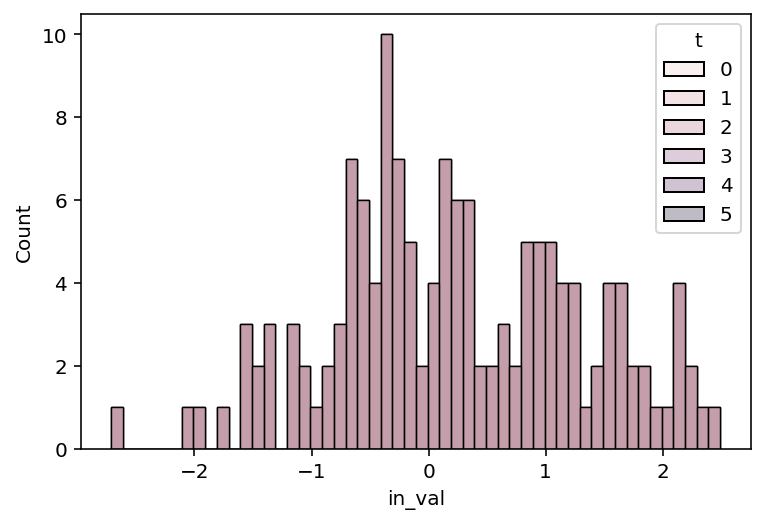

In [ ]:
sns.histplot(x="in_val", hue="t", binwidth=0.1, alpha=0.3, data=layer_df)

<AxesSubplot:xlabel='out_val', ylabel='Count'>

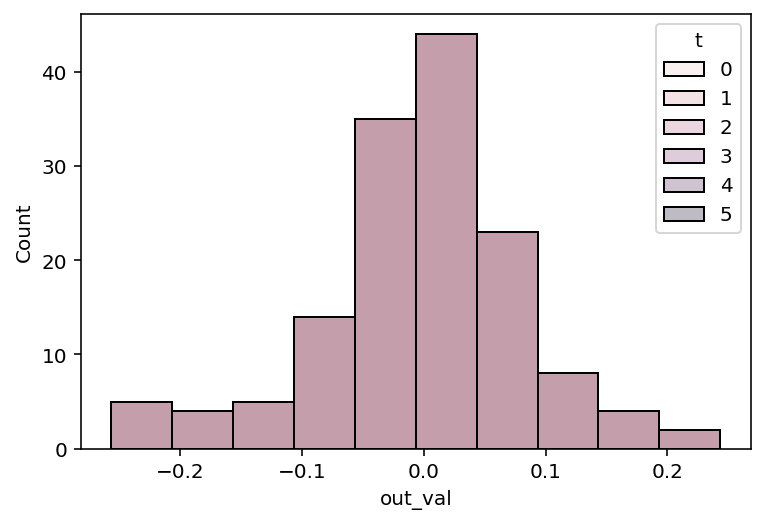

In [116]:
sns.histplot(x="out_val", hue="t", binwidth=0.05, alpha=0.3, data=layer_df)

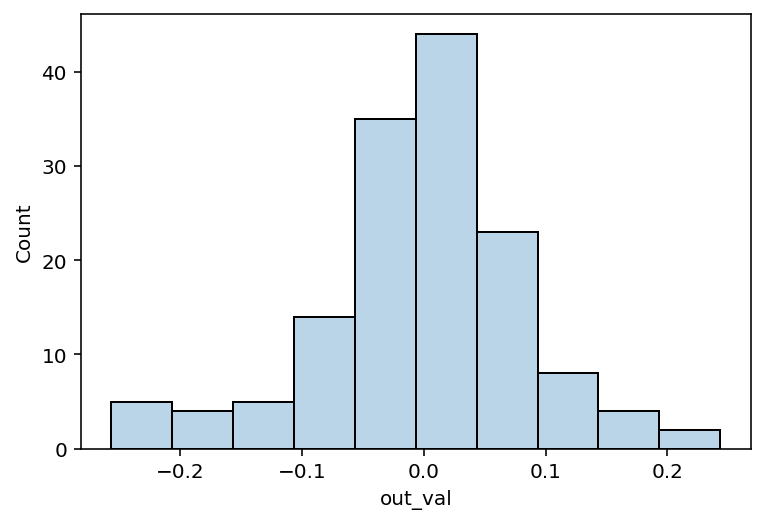

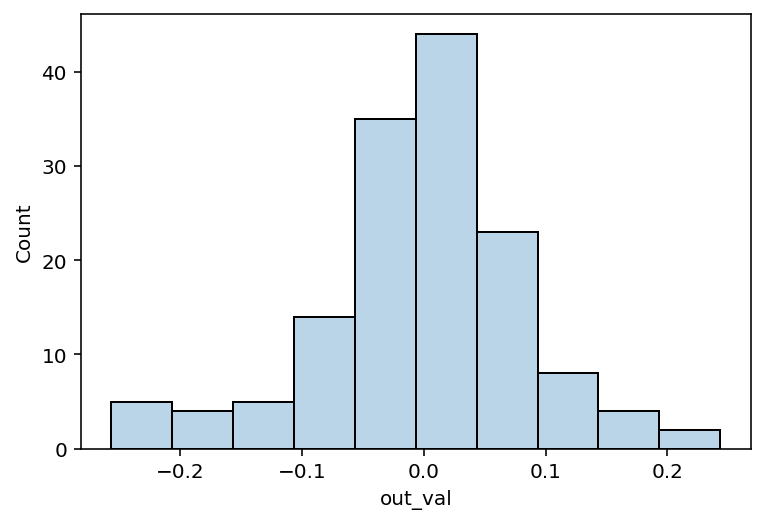

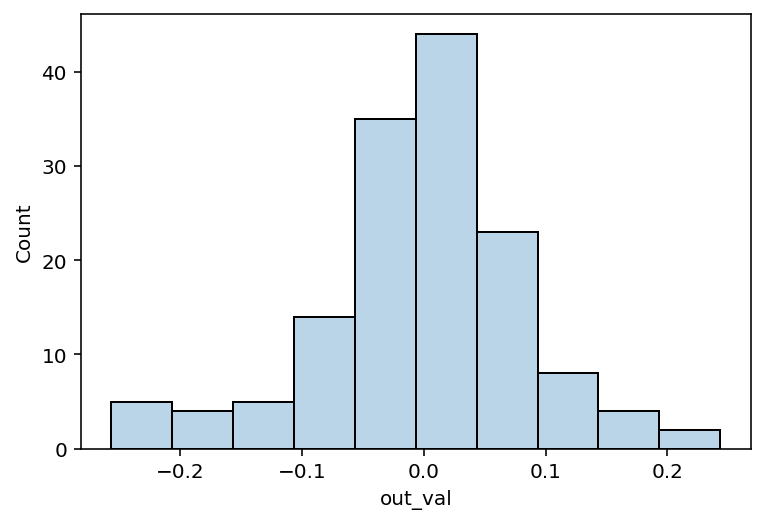

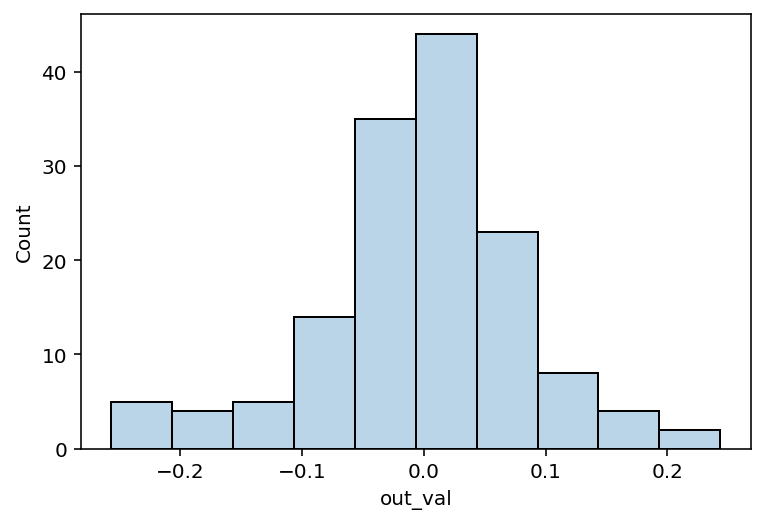

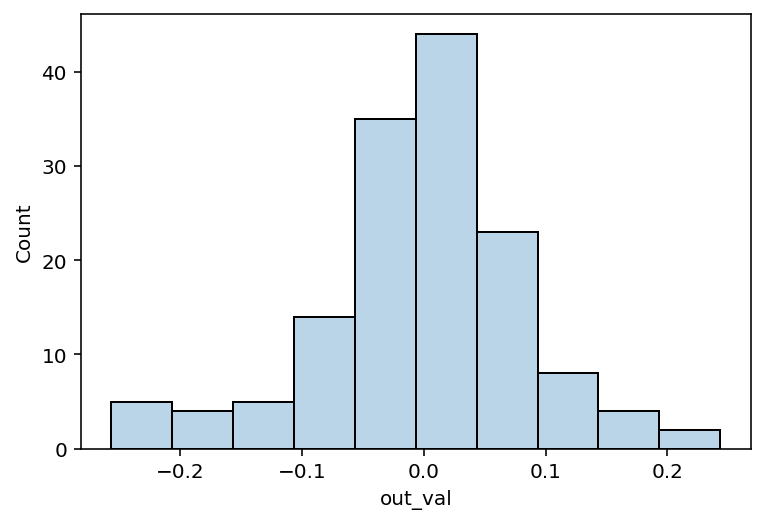

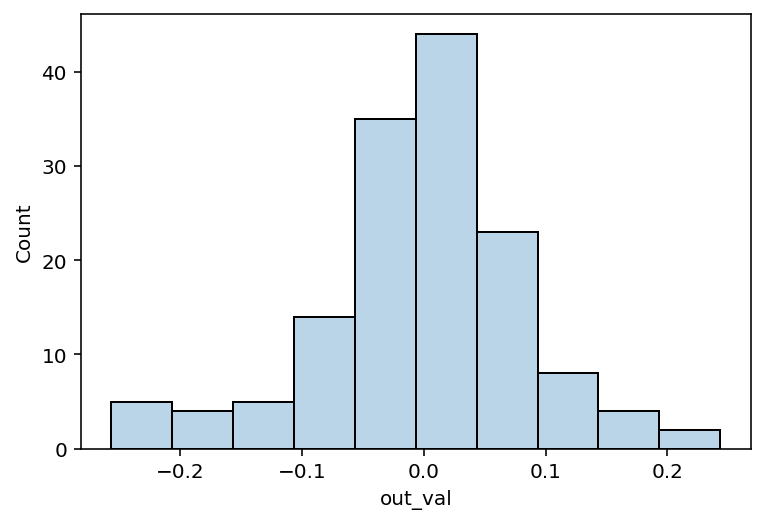

<Figure size 432x288 with 0 Axes>

In [118]:
for t, t_df in layer_df.groupby("t"):
  sns.histplot(x="out_val", data=t_df, binwidth=0.05, alpha=0.3)
  plt.show()
  plt.clf()

In [110]:
layer_df.head()

,in_val,out_val,layer,t
0,0.777671,0.048123,hgs.0.encode_1.0.identity_mapping,0
1,1.592318,0.049303,hgs.0.encode_1.0.identity_mapping,0
2,-0.623521,-0.051820,hgs.0.encode_1.0.identity_mapping,0
3,0.350525,0.054187,hgs.0.encode_1.0.identity_mapping,0
4,-0.619591,-0.094506,hgs.0.encode_1.0.identity_mapping,0


In [ ]:
# net = pose_resnet.get_pose_net(config, is_train=False)

In [ ]:
net.timesteps

In [ ]:
n_params = count_parameters(net, trainable=False)
print(f"n_params: {n_params:,}")

In [ ]:
# X = torch.zeros((4, 3, 256, 256))

In [ ]:
X = torch.randint(0, 255, (4, 3, 256, 256)) / 255 * 2 - 1
X.min(), X.max()

In [ ]:
o = net(X, 3)

In [ ]:
for t in range(net.timesteps):
  print("T: ", t)
  o = net(X, t)
  print("\n")

In [ ]:
outs = []
for t in range(net.timesteps):
  print(t)
  out = net(X, t=t)
  outs.append(out)

In [ ]:
for t, out in enumerate(outs):
  x1 = out.sum()
  print(t, x1)